# Experiment: Image Classifier - using DenseNet pre-trained network on CIFAR10 dataset

In this simple experiment, in order to reinforce what I am learning about deep neural network, I use `DenseNet`, a neural network that is pre-trained and available through the `torchvision` module in order to train a neural network to classify the CIFAR10 image dataset into 10 labels.

`DenseNet` was trained on *ImageNet*, a massive dataset with 1 million labeled images. It has a stack of convolutional layers and a classifier. Here, I will experiment by replacing the `classifier` part with a simple network with a hidden layer that will output 10 probabilities corresponding to 10 labels in this CIFAR10 dataset. The rest of the network is frozen so we can make use of the pre-trained parameters.

Because `DenseNet` has been pre-trained, the expectation is that it can detect features very well, so that a simple classifier can be plugged in to make the whole network train easily on a new image dataset, and the test accuracy is expected to be high.

This experiment follows the instructions from Udacity's Intro to Neural Network with Pytorch. 

## Result

On Udacity's GPU-enabled workspace, running one epoch (about 800 batches of 64 images) takes about 1 hour, and the testing accuracy was at 80%.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transforms

train_transform = transforms.Compose([
    # transforms.RandomRotation(30),
    # transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
])
test_transform = transforms.Compose([
    # transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
])


trainset = torchvision.datasets.CIFAR10('./CIFAR10_data/', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


testset = torchvision.datasets.CIFAR10('./CIFAR10_data/', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


labels.shape = torch.Size([5])
images.shape = torch.Size([5, 3, 224, 224])
truck


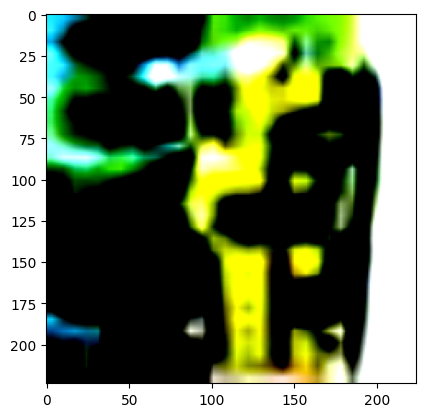

cat


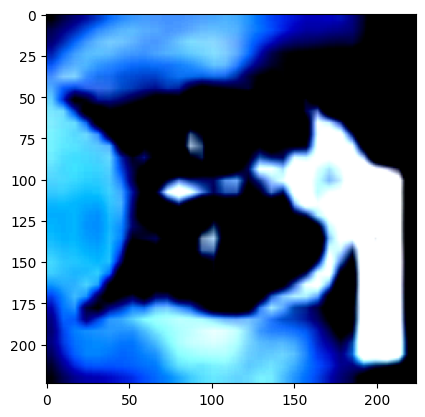

deer


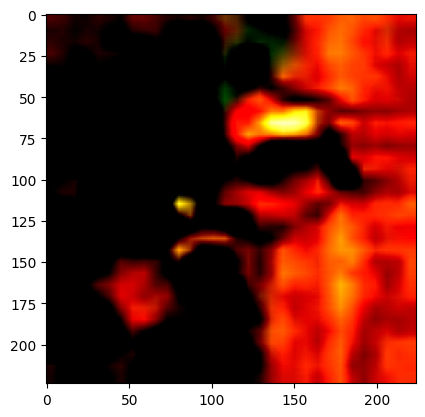

deer


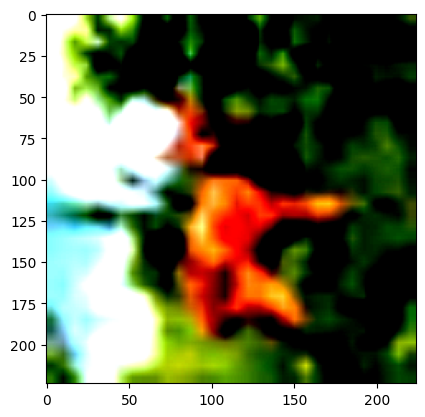

plane


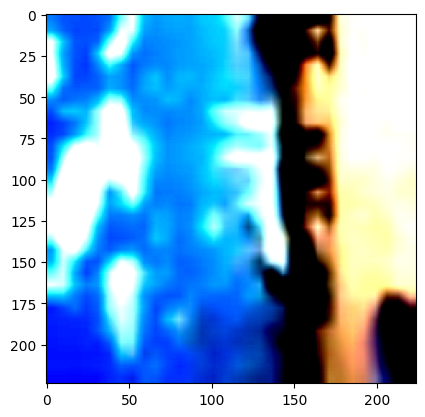

In [3]:
# Show some sample images. These images look wierd because their color values have been transformed and normalized
dataiter = iter(trainloader)
batch = next(dataiter)
labels = batch[1][0:5]
print(f"labels.shape = {labels.shape}")
images = batch[0][0:5]
print(f"images.shape = {images.shape}")
for i in range(5):
    print(classes[labels[i]])

    image = images[i].numpy()
    
    # Clipping the color values into the valid range [0..1] for imshow
    image[image < 0] = 0
    image[image > 1] = 1

    plt.imshow(image.T)
    plt.show()

In [4]:
# using a pretrained DenseNet model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.densenet121(pretrained=True)

# freeze parameters of DenseNet so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

C:\Users\Thuan Nguyen\.conda\envs\UdacityAI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Thuan Nguyen\.conda\envs\UdacityAI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model.classifier = nn.Sequential(
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, len(classes)),
    nn.LogSoftmax(dim=1)
)
criterion = nn.NLLLoss()

# only train the parameters of the classifier, and not the frozen parameters
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
num_epochs = 2
steps = 0
running_loss = 0
print_every_steps = len(trainloader) // 10
# validate_every = len(trainloader) // 6
save_model_every = len(trainloader) // 10
running_loss_array = []
testing_loss_records = {}
accuracy_records = {}

for epoch in range(num_epochs):
    for inputs, labels in trainloader:
        steps += 1
        print(f"In train step #{steps}")
        inputs, labels = inputs.to(device), labels.to(device)
        
        log_probs = model.forward(inputs)
        loss = criterion(log_probs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every_steps == 0:
            print(f"In epoch {epoch+1}/{num_epochs}.. "
                  f"Train loss: {running_loss/print_every_steps:.4f}.. ")
            running_loss_array.append(running_loss / print_every_steps)
            running_loss = 0
            
        if steps % save_model_every == 0:
            classifier_checkpoint = {
                        'classifier_state_dict': model.classifier.state_dict(),
                    }
            torch.save(classifier_checkpoint, 'CIFAR10_checkpoint')

test_loss = 0
accuracy = 0
model.eval()
print("Validating...")
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        log_probs = model.forward(inputs)
        batch_loss = criterion(log_probs, labels)
        test_loss += batch_loss.item()
        
        # accuracy
        probs = torch.exp(log_probs)
        top_prob, top_class = probs.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    else:
        print(f"Test loss: {test_loss/len(testloader):.4f}.. "
              f"Test accuracy: {accuracy/len(testloader):.4f}.. ")
    testing_loss_records[len(running_loss_array)] = test_loss/len(testloader)
    accuracy_records[len(running_loss_array)] = accuracy / len(testloader)
model.train()
            